In [78]:
#importing library files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna


In [3]:
#datasets
quantity = pd.read_excel('ProductA.xlsx')
clicks = pd.read_excel('ProductA_google_clicks.xlsx')
impression = pd.read_excel('ProductA_fb_impressions.xlsx')

In [4]:
#merging
merged = pd.read_excel('ProductA_google_clicks.xlsx').merge(pd.read_excel('ProductA_fb_impressions.xlsx'),on="Day Index").merge(pd.read_excel('ProductA.xlsx'),on="Day Index")

In [5]:
merged.head()

,Day Index,Clicks,Impressions,Quantity
0,2021-12-01,445,620,14
1,2021-12-02,433,890,10
2,2021-12-03,424,851,13
3,2021-12-04,427,881,22
4,2021-12-05,451,678,33


In [6]:
merged.tail()

,Day Index,Clicks,Impressions,Quantity
207,2022-06-26,114,1218,13
208,2022-06-27,106,1311,16
209,2022-06-28,109,885,13
210,2022-06-29,60,1000,16
211,2022-06-30,65,875,8


In [7]:
merged.shape

(212, 4)

In [8]:
#summary
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Clicks       212 non-null    int64         
 2   Impressions  212 non-null    int64         
 3   Quantity     212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [9]:
#describing 
merged.describe()

,Day Index,Clicks,Impressions,Quantity
count,212,212.00000,212.000000,212.000000
mean,2022-03-16 12:00:00,358.20283,1531.702830,17.542453
min,2021-12-01 00:00:00,60.00000,620.000000,5.000000
25%,2022-01-22 18:00:00,154.00000,1209.750000,13.750000
50%,2022-03-16 12:00:00,402.50000,1460.000000,17.000000
75%,2022-05-08 06:00:00,492.75000,1862.000000,21.000000
max,2022-06-30 00:00:00,726.00000,2707.000000,38.000000
std,NaN,164.52160,440.660783,5.790423


In [10]:
merged.isnull().sum()

Day Index      0
Clicks         0
Impressions    0
Quantity       0
dtype: int64

OUTLIERS ANALYSING

<Axes: >

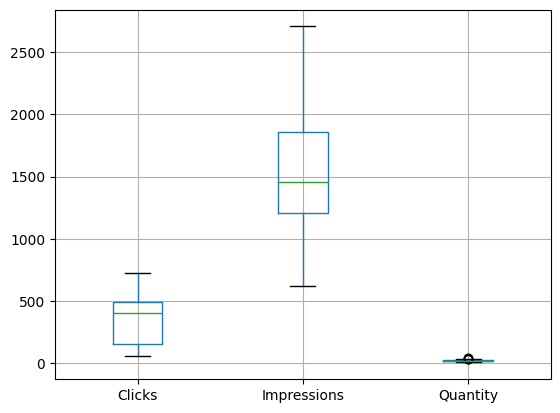

In [11]:
merged.boxplot()

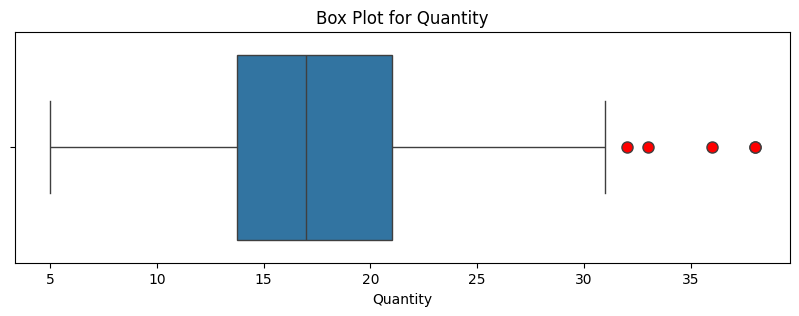

In [12]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Quantity'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Quantity")
plt.title("Box Plot for Quantity")
plt.show()

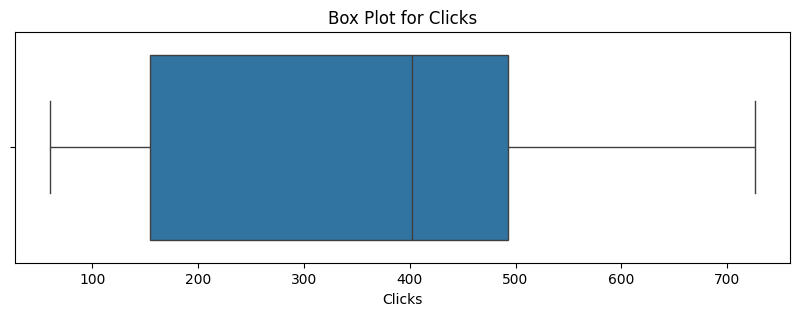

In [13]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Clicks'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Clicks")
plt.title("Box Plot for Clicks")
plt.show()

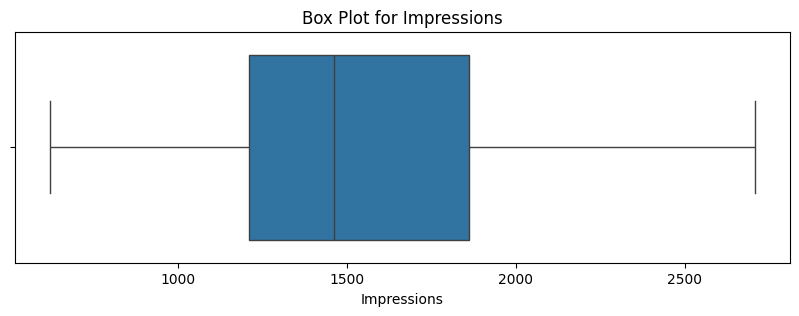

In [14]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=merged['Impressions'], flierprops=dict(marker='o', markerfacecolor="red", markersize=8))
plt.xlabel("Impressions")
plt.title("Box Plot for Impressions")
plt.show()

Check for ouliers in each column

In [15]:
def outlier_finding(merged):
    q1 , q3 = merged.quantile(0.25), merged.quantile(0.75)
    IQR = q3 - q1
    outliers = merged[(merged < (q1 - 1.5 *IQR))| (merged > (q3 + 1.5 * IQR))]
    return outliers
outlier_quantity = len(outlier_finding(merged['Quantity']))
outlier_clicks = len(outlier_finding(merged['Clicks']))
outlier_impressions = len(outlier_finding(merged['Impressions']))
#printing outliers
print("Outliers in Quantity:",outlier_quantity)
print("Outliers in Clicks:",outlier_clicks)
print("Outlier in Impressions:",outlier_impressions)

Outliers in Quantity: 5
Outliers in Clicks: 0
Outlier in Impressions: 0


So there are 5 outliers in quantity

In [16]:
print("Quantity: \n",outlier_finding(merged['Quantity']))

Quantity: 
 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64


Replacing the outlier with 96th percentile

In [17]:
percentile = merged["Quantity"].quantile(0.96)
print(percentile)

28.560000000000002


In [18]:
def outlier_percentile(series):
    q1, q3 = series.quantile([0.25,0.75])
    IQR = q3 - q1
    #calculating upper and lower bound
    lower = q1 - 1.5*IQR
    upper = q3 + 1.5*IQR
    percentile_96 = series.quantile(0.96)
    return series.apply(lambda x: percentile_96 if(x < lower or x > upper)else x)
    

In [19]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [20]:
#calculating imputed quantity
print("quantity:\t",len(outlier_finding(merged['imputed_quantity'])))

quantity:	 0


Feature Engineering

In [21]:
merged.head()

,Day Index,Clicks,Impressions,Quantity,imputed_quantity
0,2021-12-01,445,620,14,14.00
1,2021-12-02,433,890,10,10.00
2,2021-12-03,424,851,13,13.00
3,2021-12-04,427,881,22,22.00
4,2021-12-05,451,678,33,28.56


In [22]:
merged['imputed_quantity'] = outlier_percentile(merged['Quantity'])

In [23]:
#transforming data to log 
merged['log_quantity'] = np.log1p(merged['Quantity'])
merged['log_clicks'] = np.log1p(merged['Clicks'])
merged['log_impression'] = np.log1p(merged['Impressions'])

In [24]:
#month year Extracting
merged['ym'] = merged['Day Index'].dt.to_period('M')

In [25]:
#month name
merged['MonthName'] = merged['ym'].dt.strftime('%B')
month_order = ['December','January','February','March','April','May','June']
merged['MonthName'] = pd.Categorical(merged['MonthName'], categories = month_order, ordered = True)

In [26]:
#days of week
merged['daysofweek'] = merged['Day Index'].dt.day_name()
order_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
merged['daysofweek'] = pd.Categorical(merged['daysofweek'], categories = order_week, ordered = True)


In [27]:
#week of month
def weekOfMonth(date):
    first_day = date.replace(day=1)
    adjusted_dom = date.day + first_day.weekday()
    return int(np.ceil(adjusted_dom/7.0))

merged['weekOfMonth'] = merged['Day Index'].apply(weekOfMonth)

In [28]:
#extracting to numeric values
def dayToNumber(day):
    day_orders = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    return day_orders.get(day,0)

def monthToNumber(month):
    month_orders = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    return month_orders.get(month,0)

merged['daysOfWeekNum'] = merged['daysofweek'].apply(dayToNumber)
merged['MonthNum'] = merged['MonthName'].apply(monthToNumber)

In [29]:
#weekdays and months in sepearate columns
merged.loc[merged['daysofweek'] == 'Monday', 'Weekday_Monday'] = 1
merged.loc[merged['daysofweek'] == 'Tuesday', 'Weekday_Tuesday'] = 1
merged.loc[merged['daysofweek'] == 'Wednesday', 'Weekday_Wednesday'] = 1
merged.loc[merged['daysofweek'] == 'Thursday', 'Weekday_Thursday'] = 1
merged.loc[merged['daysofweek'] == 'Friday', 'Weekday_Friday'] = 1
merged.loc[merged['daysofweek'] == 'Saturday', 'Weekday_Saturday'] = 1
merged.loc[merged['daysofweek'] == 'Sunday', 'Weekday_Sunday'] = 1

merged.loc[merged['MonthName'] == 'January', 'Weekday_January'] = 1
merged.loc[merged['MonthName'] == 'February', 'Weekday_February'] = 1
merged.loc[merged['MonthName'] == 'March', 'Weekday_March'] = 1
merged.loc[merged['MonthName'] == 'April', 'Weekday_April'] = 1
merged.loc[merged['MonthName'] == 'May', 'Weekday_May'] = 1
merged.loc[merged['MonthName'] == 'June', 'Weekday_June'] = 1
merged.loc[merged['MonthName'] == 'July', 'Weekday_July'] = 1
merged.loc[merged['MonthName'] == 'August', 'Weekday_August'] = 1
merged.loc[merged['MonthName'] == 'September', 'Weekday_September'] = 1
merged.loc[merged['MonthName'] == 'October', 'Weekday_October'] = 1
merged.loc[merged['MonthName'] == 'November', 'Weekday_November'] = 1
merged.loc[merged['MonthName'] == 'December', 'Weekday_December'] = 1

In [30]:
#Replacing
weekday_columns = ['Weekday_Monday','Weekday_Tuesday','Weekday_Wednesday','Weekday_Thursday','Weekday_Friday','Weekday_Saturday','Weekday_Sunday']
month_columns = ['Weekday_January','Weekday_February','Weekday_March','Weekday_April','Weekday_May', 'Weekday_June', 'Weekday_July','Weekday_August','Weekday_September','Weekday_October','Weekday_November','Weekday_December']
#fill 0 for NAN
merged[weekday_columns] = merged[weekday_columns].fillna(0)
merged[month_columns] = merged[month_columns].fillna(0)

In [31]:
merged.columns

Index(['Day Index', 'Clicks', 'Impressions', 'Quantity', 'imputed_quantity',
       'log_quantity', 'log_clicks', 'log_impression', 'ym', 'MonthName',
       'daysofweek', 'weekOfMonth', 'daysOfWeekNum', 'MonthNum',
       'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_January', 'Weekday_February',
       'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
       'Weekday_July', 'Weekday_August', 'Weekday_September',
       'Weekday_October', 'Weekday_November', 'Weekday_December'],
      dtype='object')

In [32]:
merged.head()

,Day Index,Clicks,Impressions,Quantity,imputed_quantity,log_quantity,log_clicks,log_impression,ym,MonthName,...,Weekday_March,Weekday_April,Weekday_May,Weekday_June,Weekday_July,Weekday_August,Weekday_September,Weekday_October,Weekday_November,Weekday_December
0,2021-12-01,445,620,14,14.00,2.708050,6.100319,6.431331,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021-12-02,433,890,10,10.00,2.397895,6.073045,6.792344,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-12-03,424,851,13,13.00,2.639057,6.052089,6.747587,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2021-12-04,427,881,22,22.00,3.135494,6.059123,6.782192,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2021-12-05,451,678,33,28.56,3.526361,6.113682,6.520621,2021-12,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


So this the final data for future analysis

DATA ANALYSIS

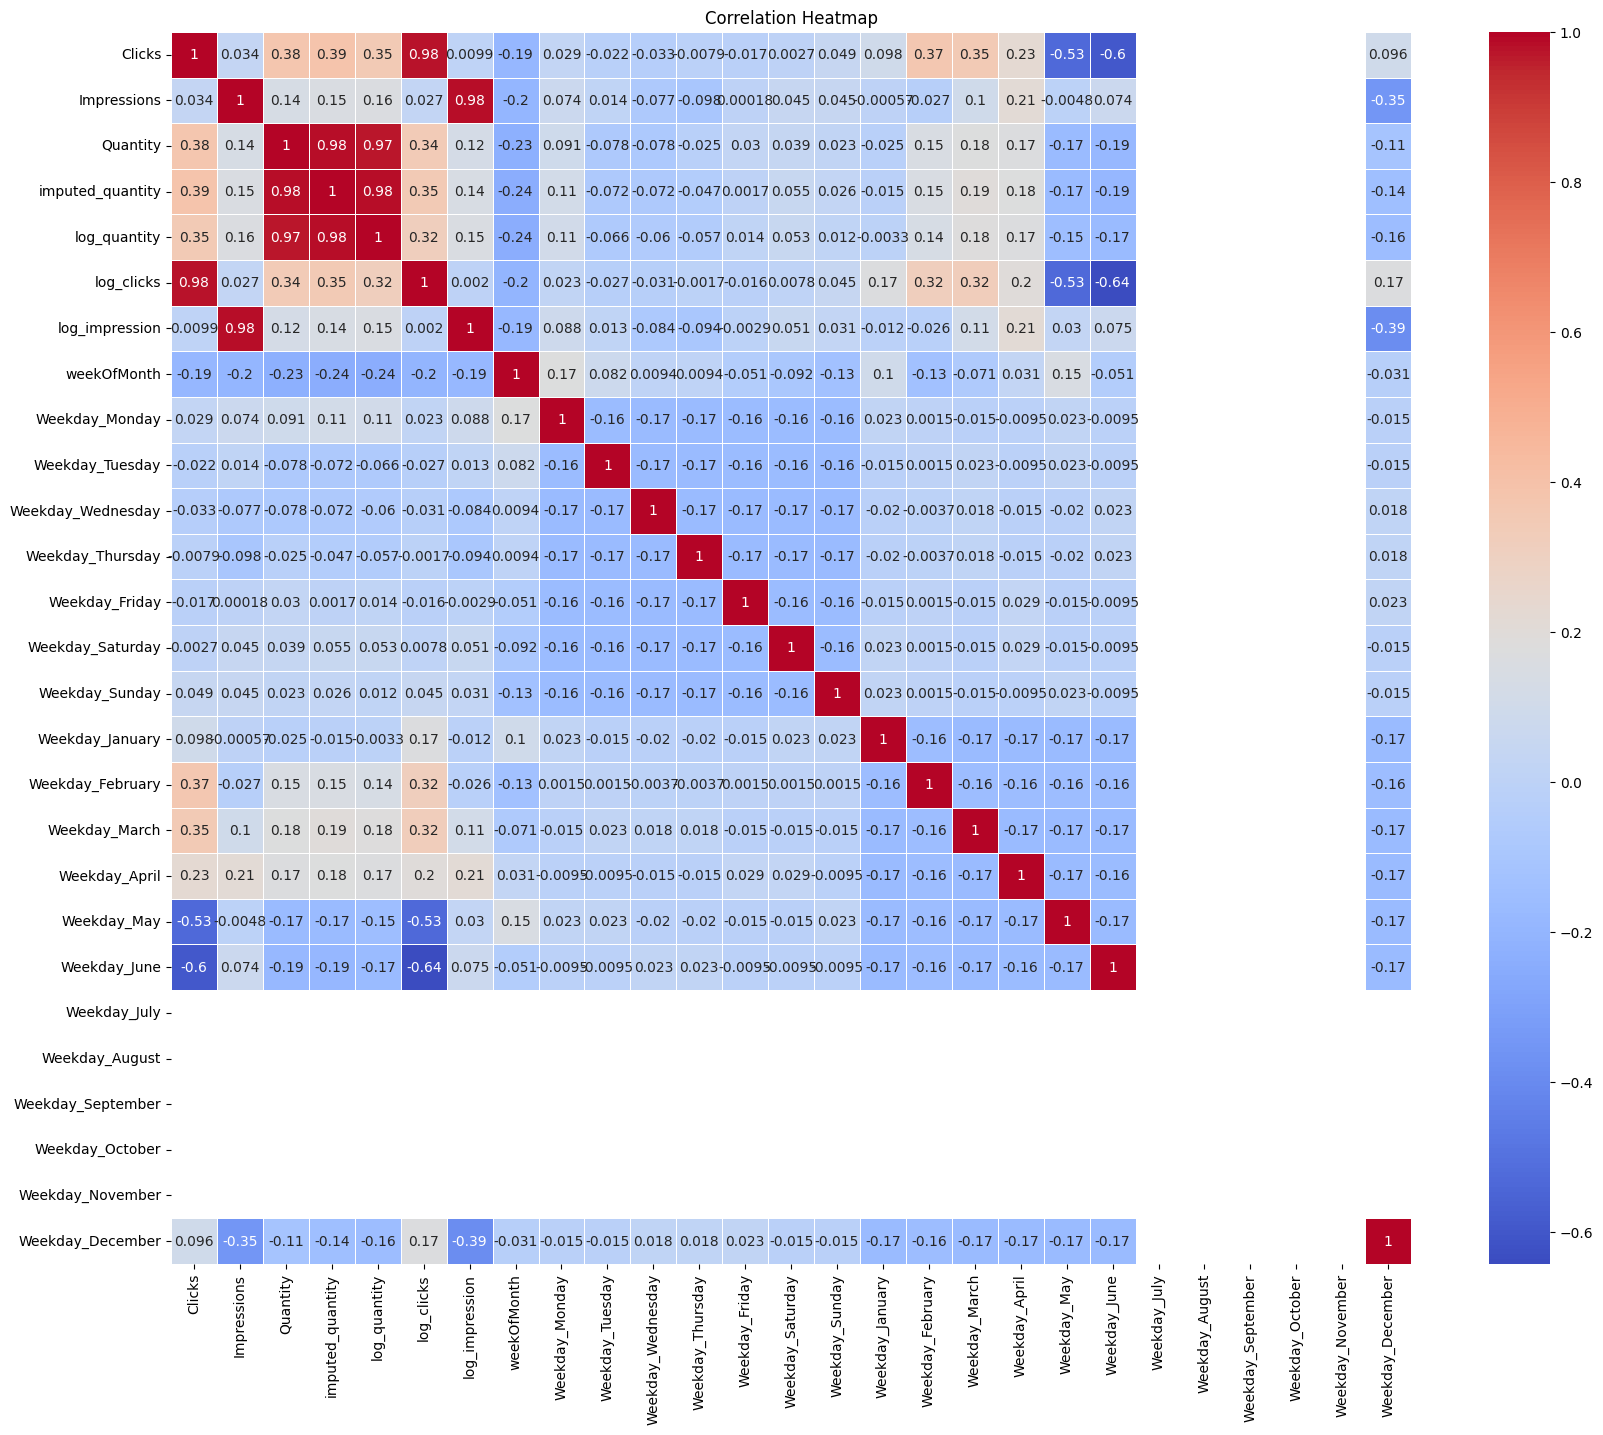

In [33]:
#correlation heatmap
plt.figure(figsize=(20,16))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5).set_title("Correlation Heatmap")
plt.show()

We know that from the above graph clicks affects the product quantity

In [34]:
def regression(merged, x_col, y_col, title, ax):
    x = merged[x_col].values.reshape(-1,1)
    y = merged[y_col].values
    model = LinearRegression()
    model.fit(x,y)
    y_pre = model.predict(x)
    #to get slope
    slope = model.coef_[0]
    ax.scatter(merged[x_col], merged[y_col], label='Actual')
    ax.plot(merged[x_col], y_pre,color='red',label='Regression')
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()
    return slope

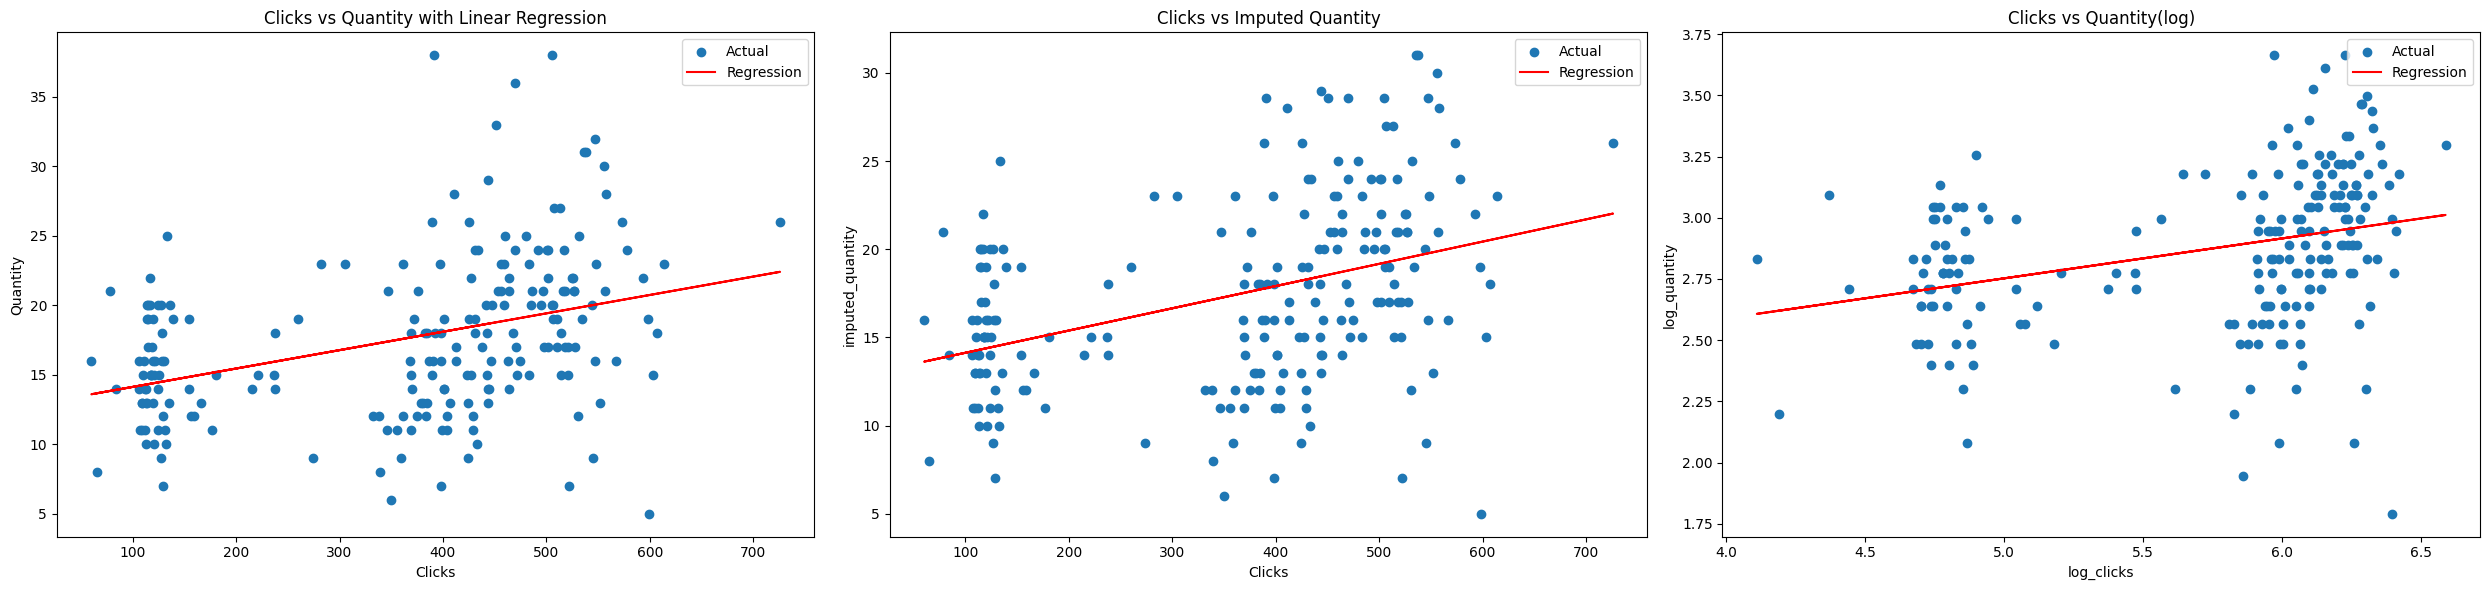

og:0.013234961483654805
imputed:0.012606614465075036
log:0.16298656613150664


In [35]:
#plotting
fig, axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged,'Clicks', 'Quantity', 'Clicks vs Quantity with Linear Regression',axes[0])
imputed = regression(merged,'Clicks', 'imputed_quantity', 'Clicks vs Imputed Quantity',axes[1])
log = regression(merged,'log_clicks', 'log_quantity', 'Clicks vs Quantity(log)',axes[2])
plt.tight_layout()
plt.show()
print(f"og:{og}")
print(f"imputed:{imputed}")
print(f"log:{log}")

Impressions affect the quantity

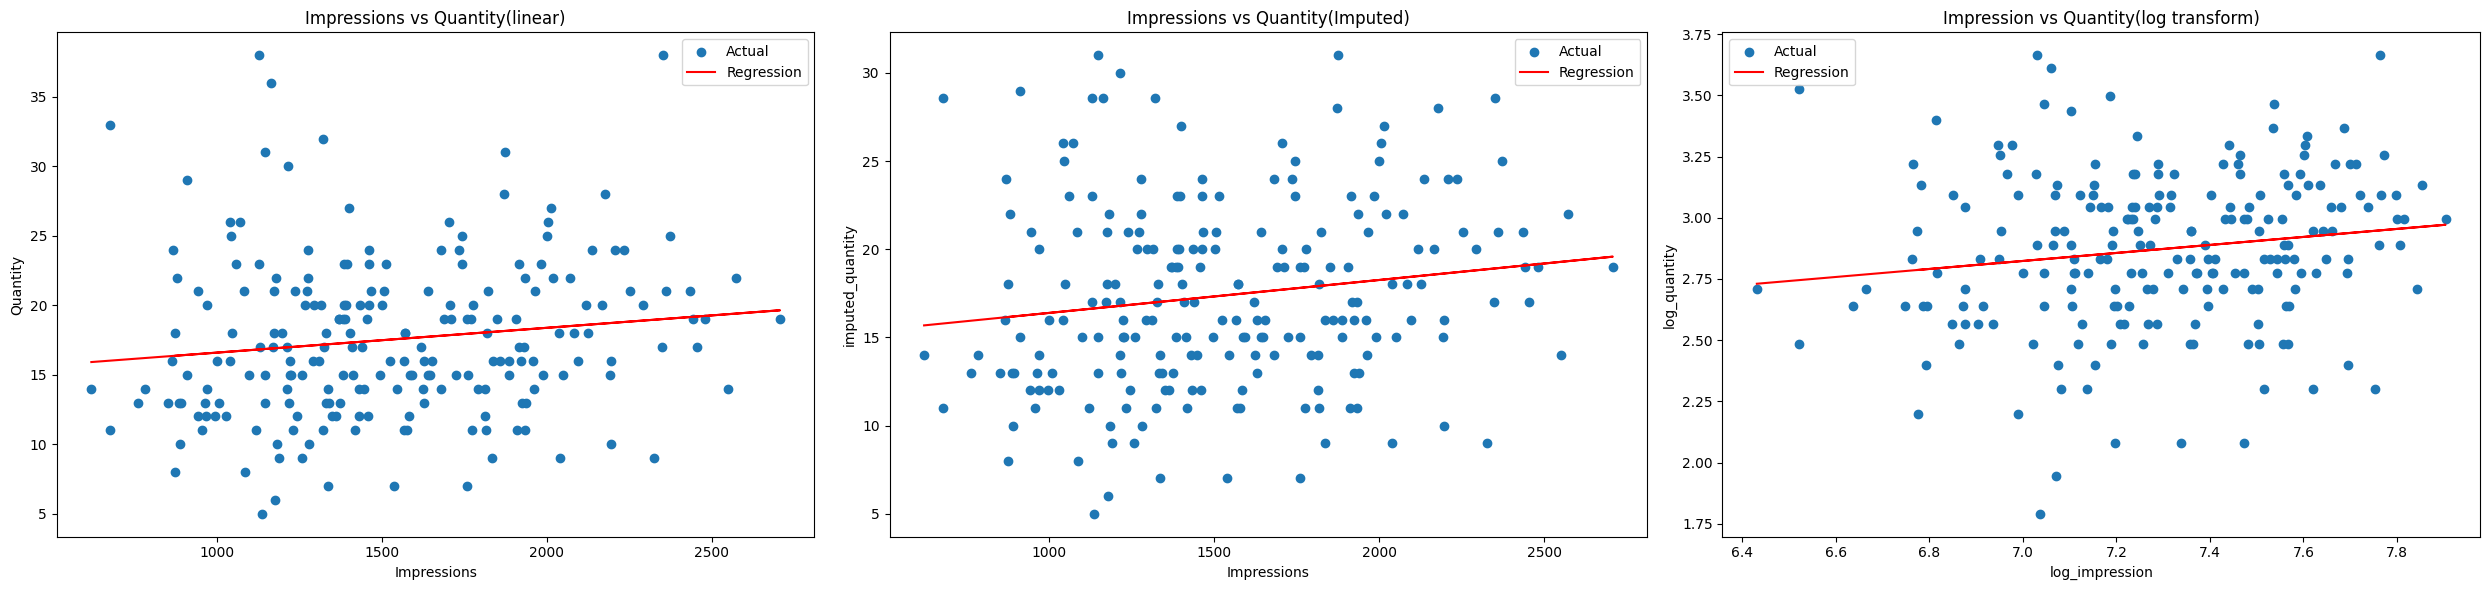

og: 0.0017863293104571235
imputed: 0.0018674999986826725
log: 0.16352913564679306


In [36]:
fig,axes = plt.subplots(1,3,figsize=(25,6))
og = regression(merged, 'Impressions','Quantity','Impressions vs Quantity(linear)',axes[0] )
imputed = regression(merged,'Impressions', 'imputed_quantity','Impressions vs Quantity(Imputed)', axes[1])
log = regression(merged, 'log_impression','log_quantity', 'Impression vs Quantity(log transform)',axes[2])
plt.tight_layout()
plt.show()
print("og:",og)
print("imputed:",imputed)
print("log:",log)


Impression leads to more clicks

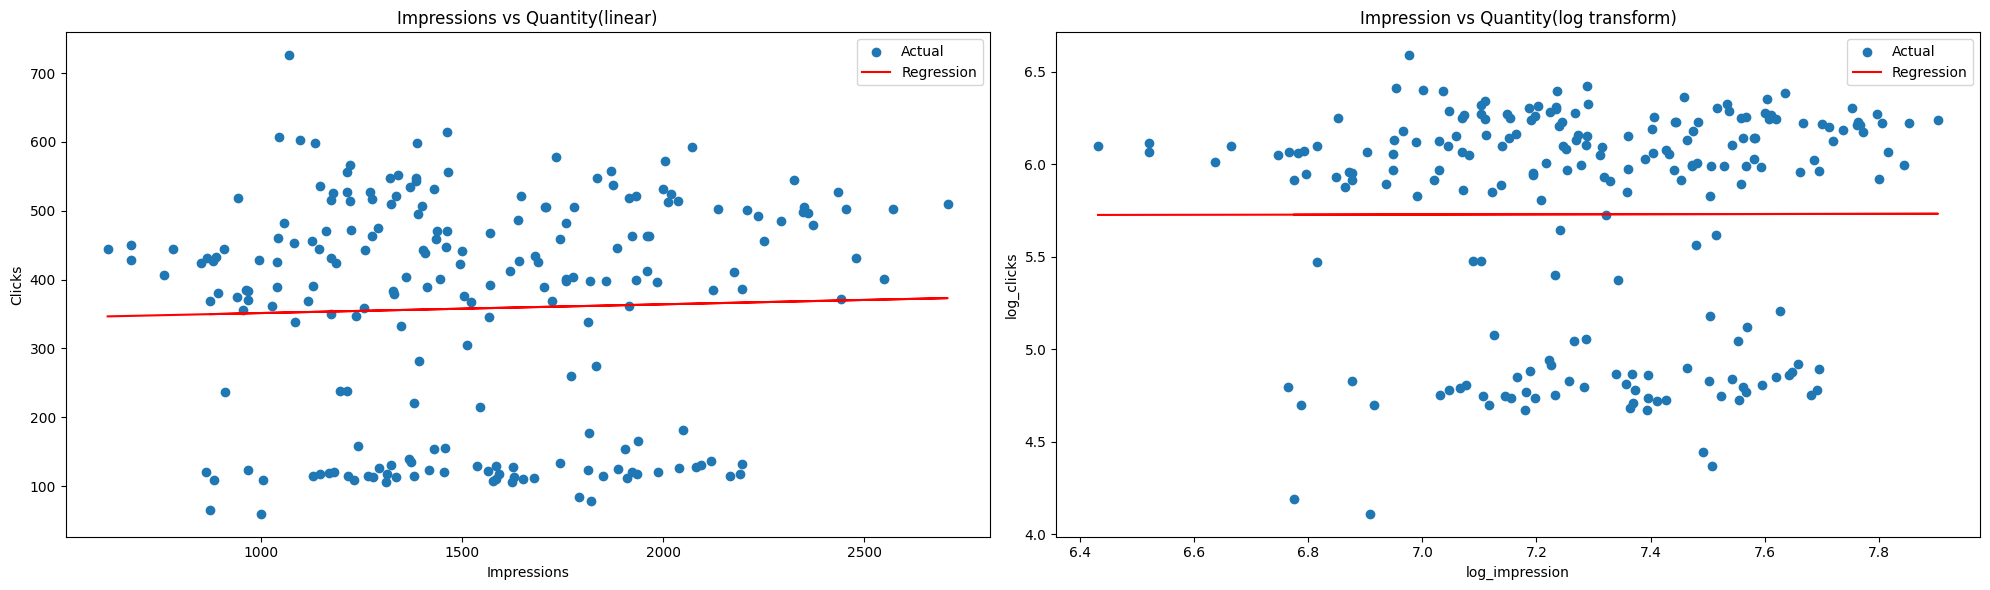

og: 0.012709310479620622
log: 0.004241626376529049


In [37]:
fig,axes = plt.subplots(1,2,figsize=(20,6))
og = regression(merged, 'Impressions','Clicks','Impressions vs Quantity(linear)',axes[0] )
log = regression(merged, 'log_impression','log_clicks', 'Impression vs Quantity(log transform)',axes[1])
plt.tight_layout()
plt.show()
print("og:",og)
print("log:",log)


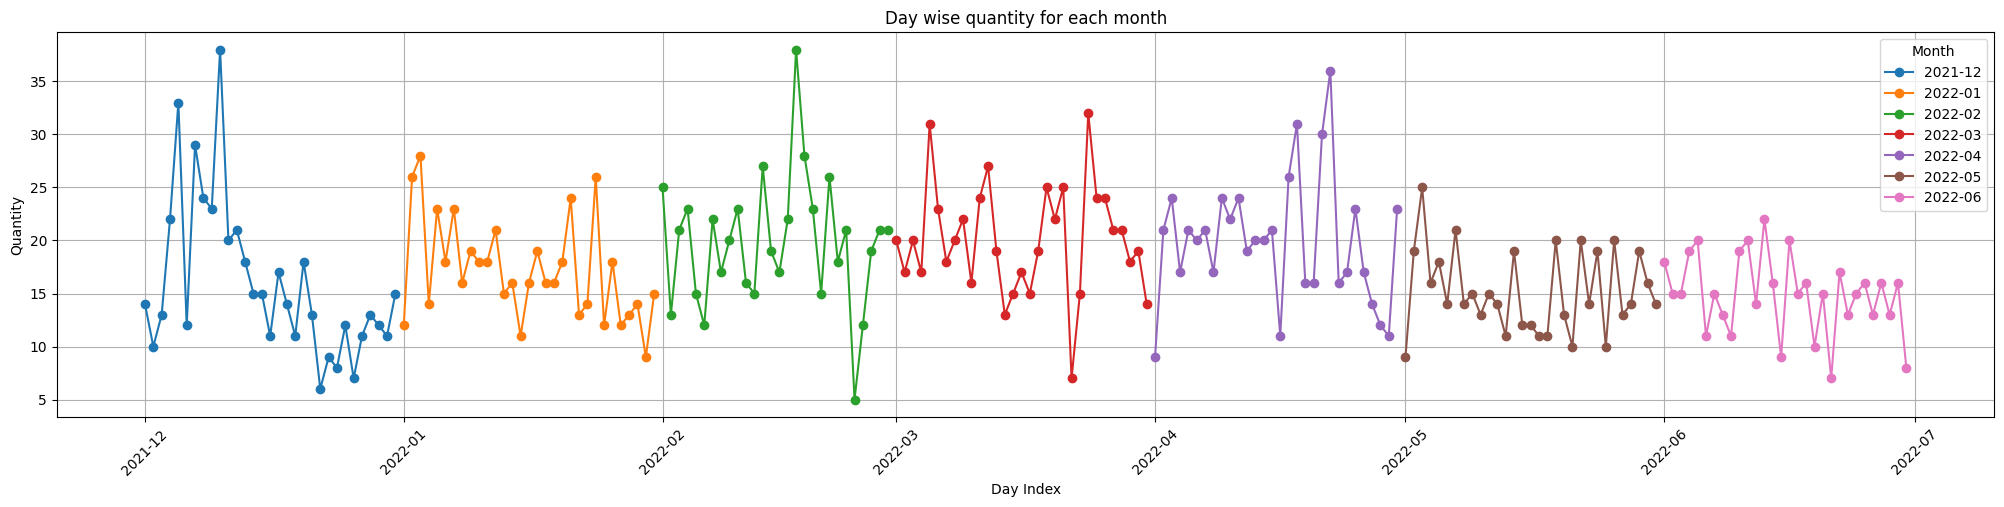

In [38]:
# day_wise plot for all 7 months for quantity
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Quantity'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()   
    

    
    

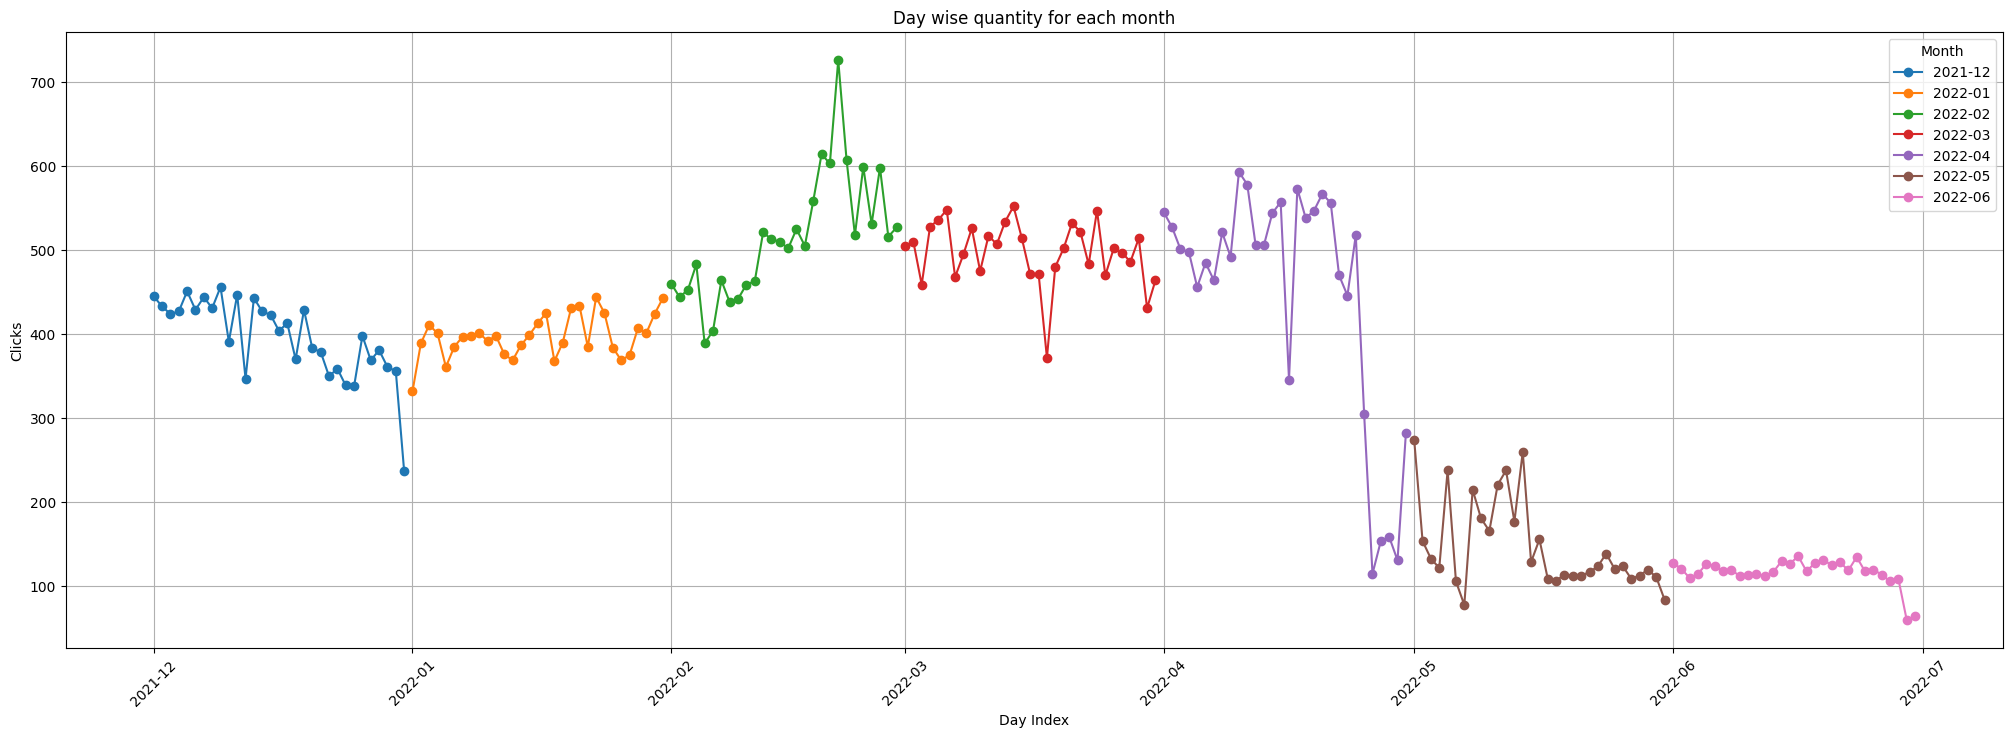

In [39]:
#clicks
plt.figure(figsize=(25,8))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Clicks'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid(True)
plt.show()   
    

    
    


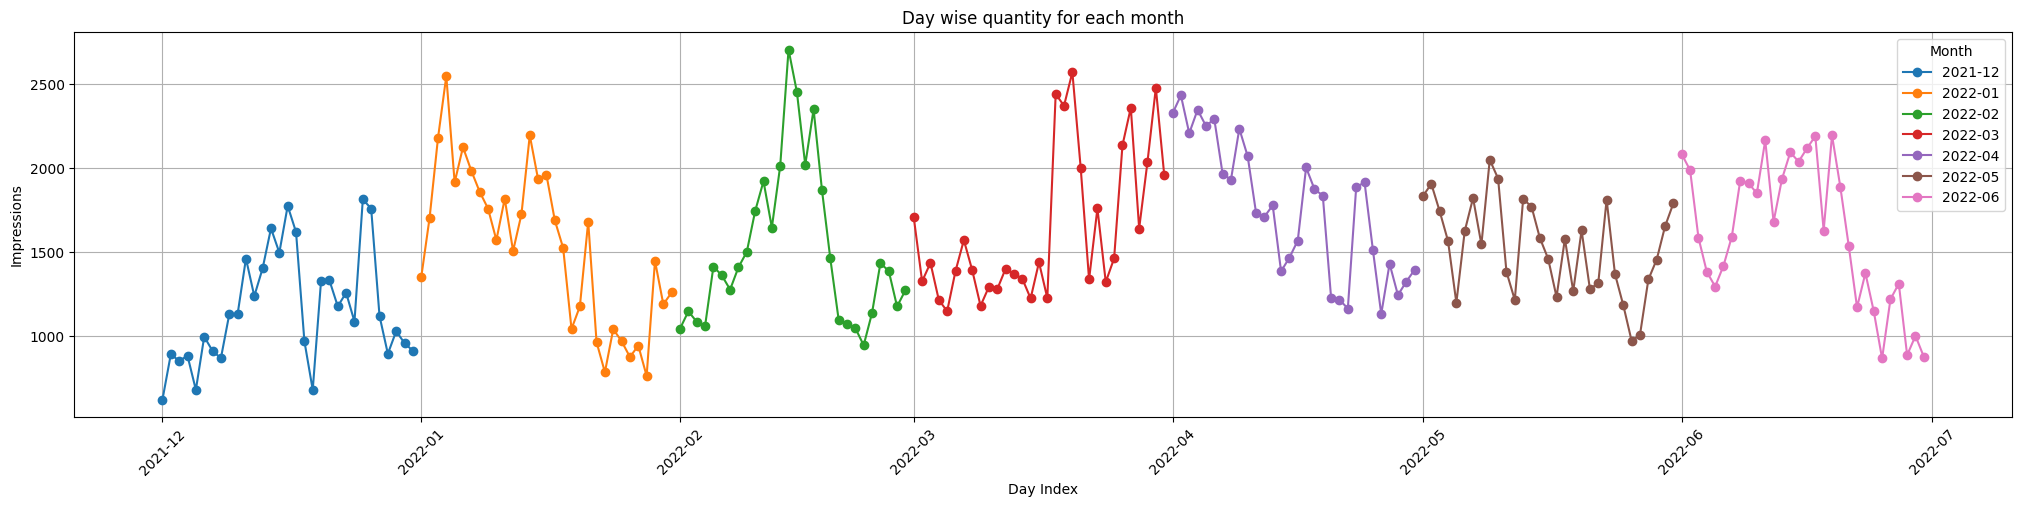

In [40]:
#impression
plt.figure(figsize=(25,5))
for month in merged['ym'].unique():
    monthly_data = merged[merged['ym']==month]
    plt.plot(monthly_data['Day Index'],monthly_data['Impressions'],marker='o',label=str(month))
    
plt.title('Day wise quantity for each month')
plt.xlabel('Day Index')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.legend(title="Month",loc='best') 
plt.grid()
plt.show()   
    

    
    

Monthly plot

In [41]:
#quantity
def annotate(ax,x,y,values):
    for i, txt in enumerate(values):
        ax.annotate(f'{txt:.0f}',(x[i],y[i]),textcoords="offset points",xytext=(0,5),ha='center')

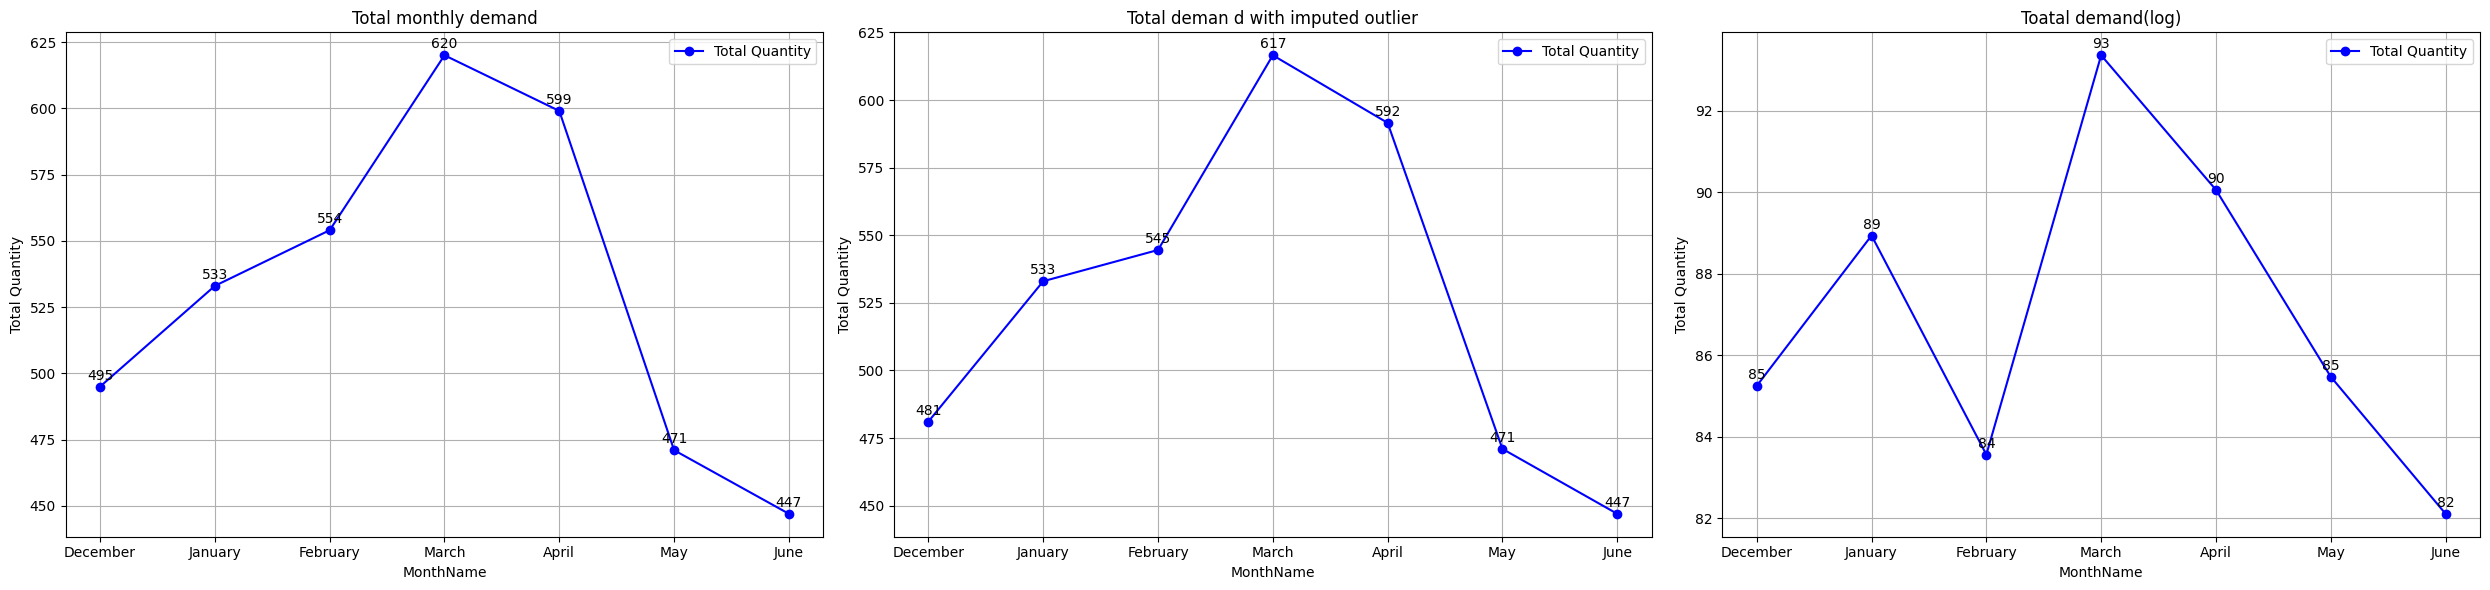

In [42]:
def plotMonthly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    ax.plot(merged1[x_col],merged1[y_col],marker='o',color='blue',label="Total Quantity")
    annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
    del merged1
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel("Total Quantity")
    ax.grid(True)
    ax.legend()
    
#ploting side by side
fig,axes = plt.subplots(1,3,figsize=(25,6))
plotMonthly(merged,'MonthName','Quantity','Total monthly demand',axes[0])
plotMonthly(merged,'MonthName','imputed_quantity','Total deman d with imputed outlier',axes[1] )
plotMonthly(merged,'MonthName','log_quantity','Toatal demand(log)',axes[2])
plt.tight_layout()
plt.show()

Hence the demand for the product increases in december (winter) arrives and reaches peak in march.

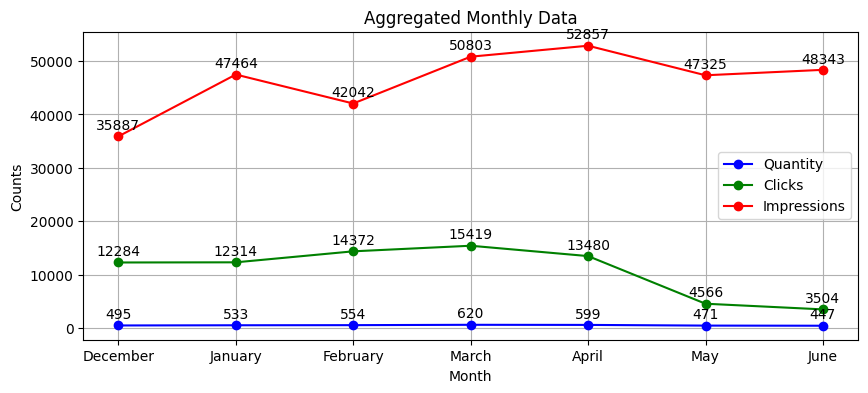

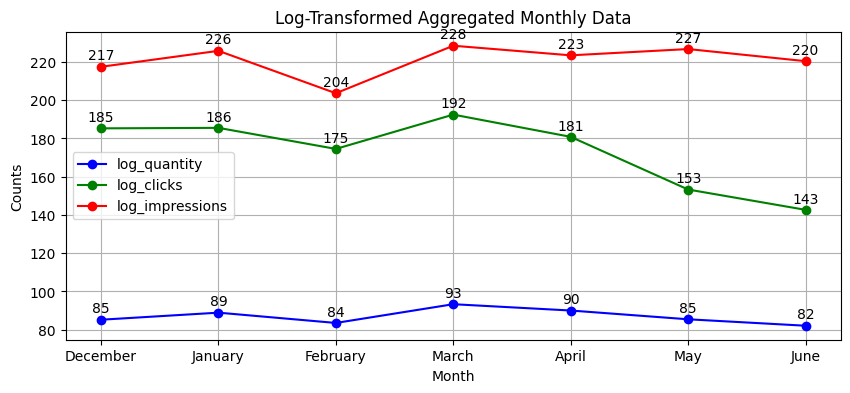

In [43]:
#for all
def plotAggregated(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,4))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregated(merged,'MonthName',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated Monthly Data')
plotAggregated(merged,'MonthName',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated Monthly Data')


We can see that there is a peak in march for all.

Days of week plot

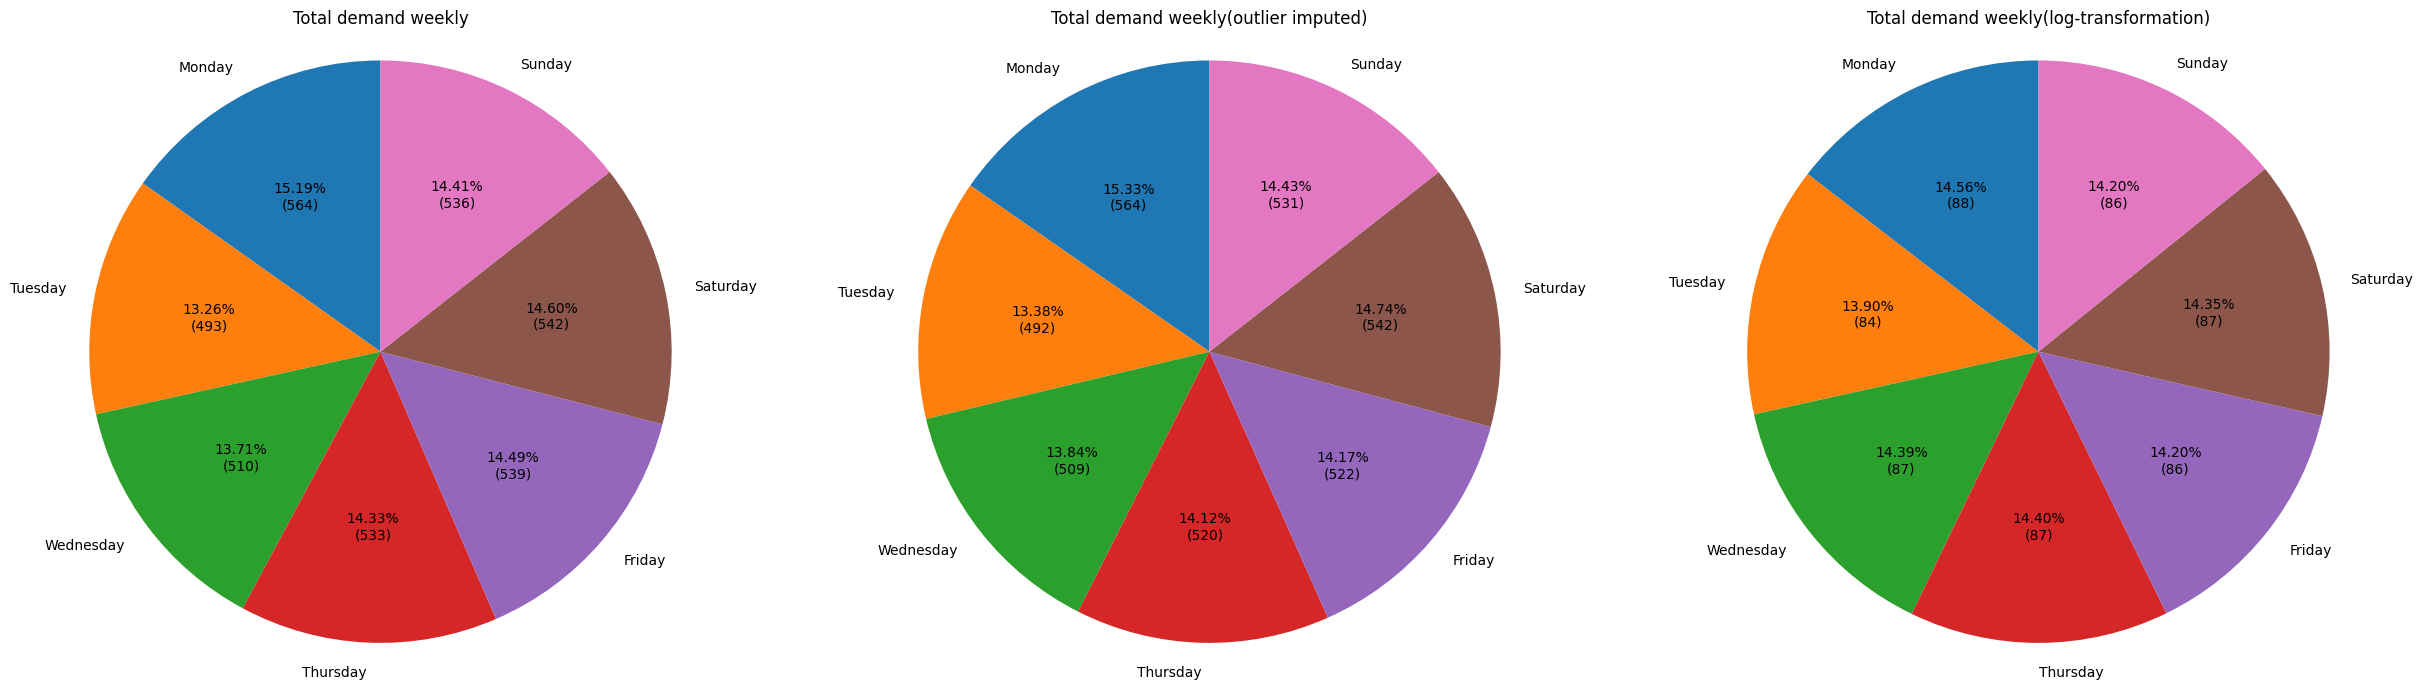

In [44]:
#quantity
def plotWeekly(merged,x_col,y_col,title,ax):
    merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
    merged1 = merged1.sort_values(by=x_col)
    labels = merged1[x_col]
    sizes = merged1[y_col]
    ax.pie(sizes,labels=labels,autopct=lambda pct: f'{pct:.2f}%\n({int(pct*sum(sizes)/100)})',startangle=90)
    ax.set_title(title)
    ax.axis('equal')
    del merged1
    
fig,axes = plt.subplots(1,3,figsize=(25,7))
plotWeekly(merged,'daysofweek','Quantity','Total demand weekly',axes[0])
plotWeekly(merged,'daysofweek','imputed_quantity','Total demand weekly(outlier imputed)',axes[1])
plotWeekly(merged,'daysofweek','log_quantity','Total demand weekly(log-transformation)',axes[2])
plt.tight_layout()
plt.show()

From we can say that monday is the peak of demand and tuesday is the lowest compared to all.

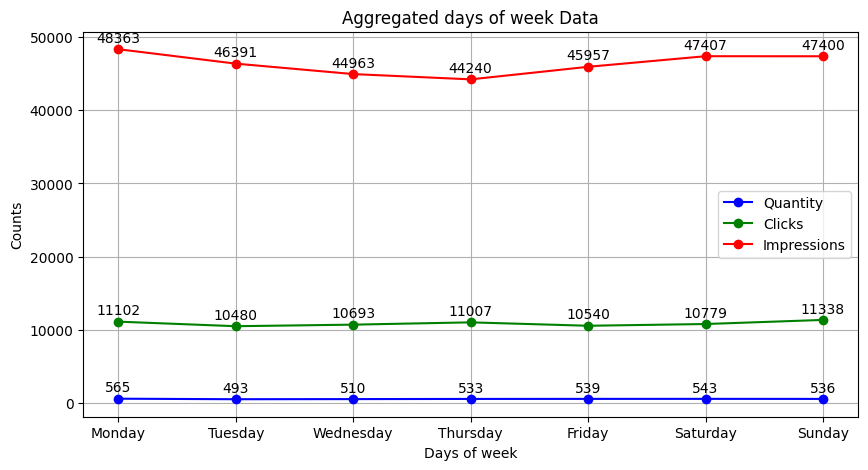

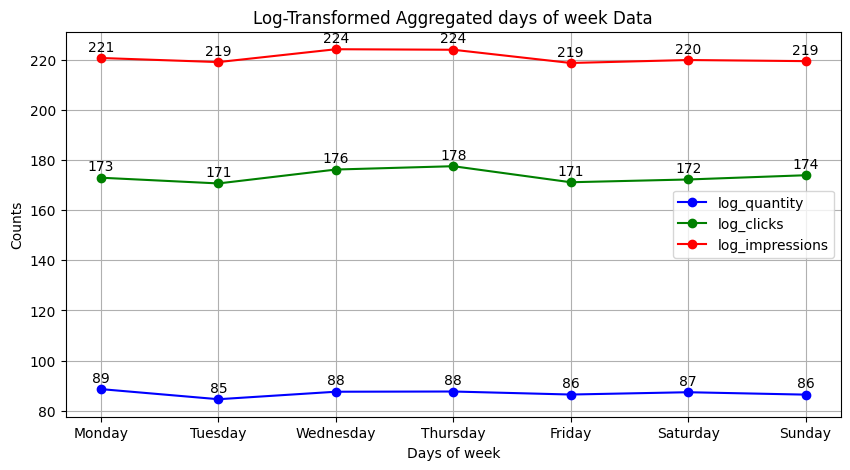

In [45]:
#for all
def plotAggregateds(merged,x_col,y_cols,colors,labels,title):
    plt.figure(figsize=(10,5))
    ax=plt.gca()
    for y_col,color,label in zip(y_cols,colors,labels):
        merged1 = merged.groupby(x_col,observed=False)[y_col].sum().reset_index()
        merged1 = merged1.sort_values(by=x_col)
        ax.plot(merged1[x_col],merged1[y_col],marker='o',color=color,label=label)
        annotate(ax,merged1[x_col],merged1[y_col],merged1[y_col])
        del merged1
    ax.set_title(title)
    ax.set_xlabel('Days of week')
    ax.set_ylabel("Counts")
    ax.grid(True)
    ax.legend()
    plt.show()
    
plotAggregateds(merged,'daysofweek',['Quantity','Clicks','Impressions'],['blue','green','red'],['Quantity','Clicks','Impressions'],'Aggregated days of week Data')
plotAggregateds(merged,'daysofweek',['log_quantity','log_clicks','log_impression'],['blue','green','red'],['log_quantity','log_clicks','log_impressions'],'Log-Transformed Aggregated days of week Data')


From original data we can say that weekends (saturday, sunday) and monday have high impressions and clicks and thursday for clicks.

In log-transformed, wednesday and thursday have high clicks and impressions.

Week-3

Time Series Modelling

In [53]:
#function to check stationary using ADF test
def checking(series):
    result = adfuller(series.dropna())
    print(f"ADF_Statistics: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1]<0.05 #if p-value is less 0.05,it's stationary
#check for stationary of the 'imputed quantity' column
is_stat = checking(merged['imputed_quantity'])
if not is_stat:
    print("It is not stationary")
else:
    print("It is stationay")


ADF_Statistics: -4.365375497923747
p-value: 0.0003416347702463347
It is stationay


It is a s stationary series as p-value less than 0.05

In [54]:
trainsize = int(0.7 * len(merged))
#define the train and test
train = merged['imputed_quantity'][:trainsize]
test = merged['imputed_quantity'][trainsize:]
exogenouscolumns = [
    'Impressions', 'Clicks', 'MonthNum', 'weekOfMonth',
    'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday',
    'Weekday_January', 'Weekday_February', 'Weekday_March', 'Weekday_April', 'Weekday_May', 'Weekday_June',
    'Weekday_July', 'Weekday_August', 'Weekday_September', 'Weekday_October', 'Weekday_November', 'Weekday_December'
]
trainexog = merged[exogenouscolumns][:trainsize] 
testexog = merged[exogenouscolumns][trainsize:] 

In [ ]:
#Function for calculating evaluation metrics
def calculatemetrics(truevalues, predictedvalues):
    mae = mean_absolute_error(truevalues, predictedvalues)
    mse = mean_squared_error(truevalues, predictedvalues)   
    rmse = np.sqrt(mse)                                  
    mape = np.mean(np.abs((truevalues - predictedvalues) / truevalues)) * 100
    return mae, rmse, mse, mape


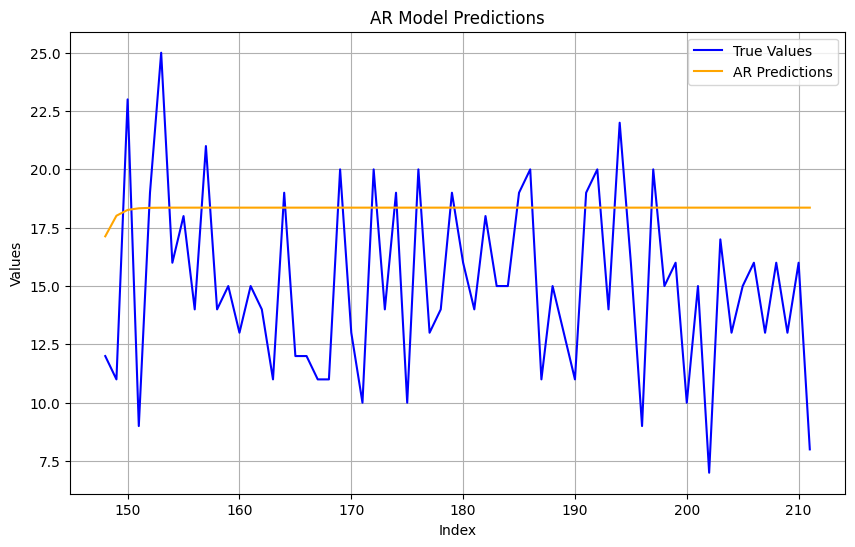

AR Model Metrics: mae=4.250673053308261, rmse=5.029975414318682, mse=25.300652668650393, mape=35.07%


In [57]:
#function for plotting
def plotmodelpredictions(truevalues, predictedvalues, modelname):
    plt.figure(figsize=(10, 6))
    plt.plot(truevalues.index, truevalues, label='True Values', color='blue')
    plt.plot(truevalues.index, predictedvalues, label=f'{modelname} Predictions', color='orange')
    plt.legend()
    plt.title(f'{modelname} Model Predictions')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

armodel = ARIMA(train, order=(1, 0, 0))
armodelfit = armodel.fit()
arpredictions = armodelfit.forecast(len(test))

plotmodelpredictions(test, arpredictions, "AR")
armetrics = calculatemetrics(test, arpredictions)
print(f"AR Model Metrics: mae={armetrics[0]}, rmse={armetrics[1]}, mse={armetrics[2]}, mape={armetrics[3]:.2f}%")

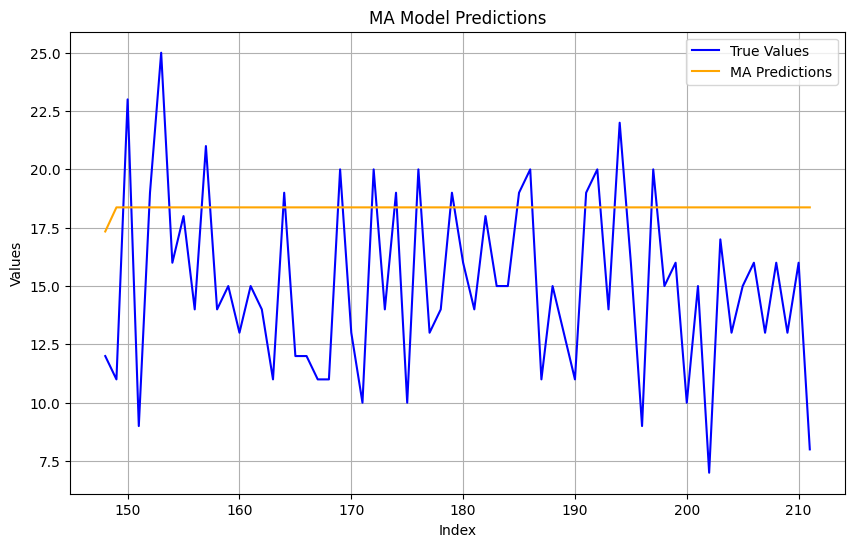

In [59]:
mamodel = ARIMA(train, order=(0, 0, 1))
mamodelfit = mamodel.fit()
mapredictions = mamodelfit.forecast(len(test))

# Plot and Evaluate MA Model
plotmodelpredictions(test, mapredictions, "MA")
ma_metrics = calculatemetrics(test, mapredictions)

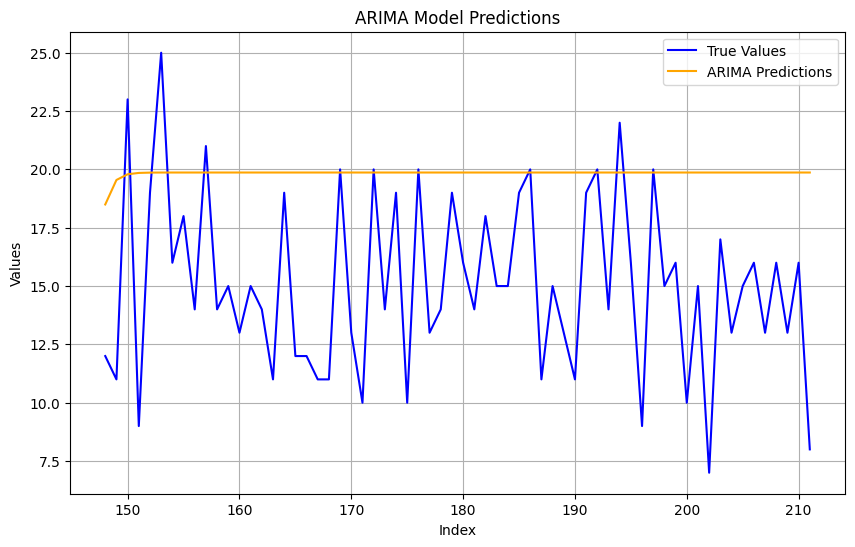

In [69]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_predictions = arima_model_fit.forecast(len(test))

# Plot and Evaluate ARIMA Model
plotmodelpredictions(test, arima_predictions, "ARIMA")
arima_metrics = calculatemetrics(test, arima_predictions)

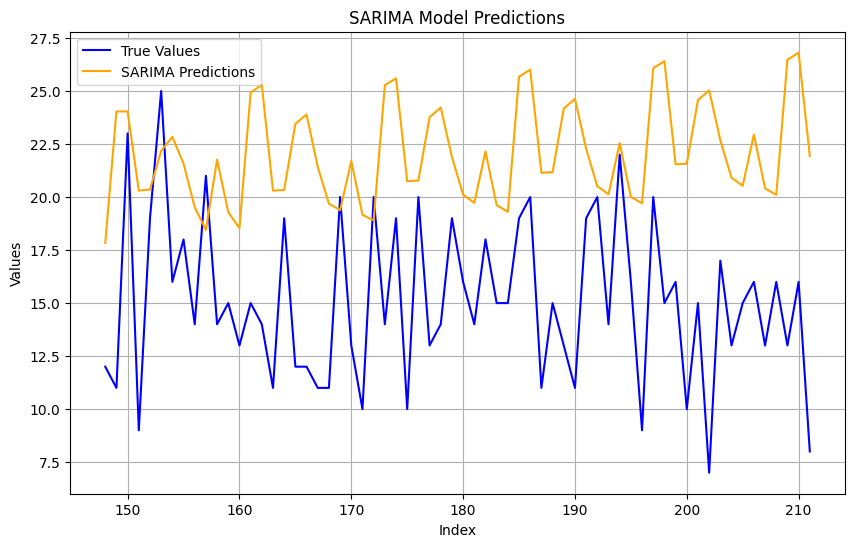

In [70]:
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()
sarima_predictions = sarima_model_fit.forecast(len(test))

# Plot and Evaluate SARIMA Model
plotmodelpredictions(test, sarima_predictions, "SARIMA")
sarima_metrics = calculatemetrics(test, sarima_predictions)

Seasonality captured but modelling to be perfectly by doing hyparameter tuning.

C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


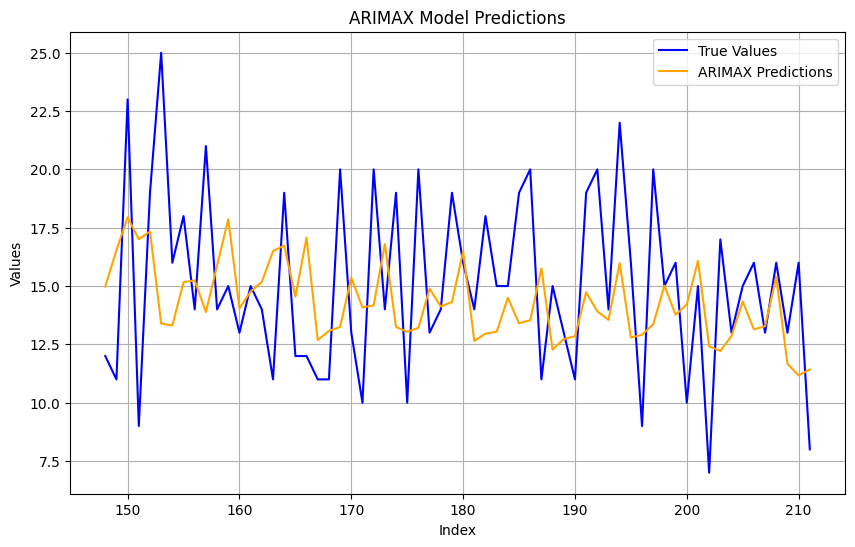

In [72]:
arimax_model = ARIMA(train, order=(1, 1, 1), exog=trainexog)  # ARIMAX includes exogenous variables
arimax_model_fit = arimax_model.fit()
arimax_predictions = arimax_model_fit.forecast(len(test), exog=testexog)

# Plotting the predictions
plotmodelpredictions(test, arimax_predictions, "ARIMAX")

# Calculate metrics
arimax_metrics = calculatemetrics(test, arimax_predictions)

Seasonality captured but modelling to be perfectly by doing hyparameter tuning.

C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


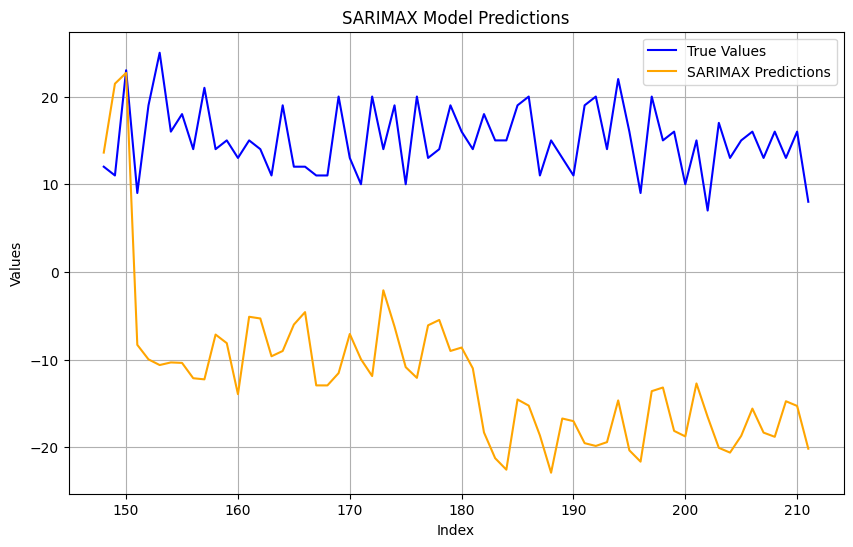

In [73]:
sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=trainexog)  # SARIMAX includes exogenous variables
sarimax_model_fit = sarimax_model.fit()
sarimax_predictions = sarimax_model_fit.forecast(len(test), exog=testexog)

# Plotting the predictions
plotmodelpredictions(test, sarimax_predictions, "SARIMAX")

# Calculate metrics
sarimax_metrics = calculatemetrics(test, sarimax_predictions)

Seasonality caputured but modelling to be perfect by doing hyperparameter tunning

In [74]:
# Evaluation metrics before hyperparameter tuning
metrics_before = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_metrics[0], sarimax_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_metrics[1], sarimax_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_metrics[2], sarimax_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_metrics[3], sarimax_metrics[3]],
})
print("Metrics Before Tuning")
print(metrics_before)

Metrics Before Tuning
     Model        MAE       RMSE         MSE        MAPE
0       AR   4.250673   5.029975   25.300653   35.067471
1       MA   4.263641   5.047676   25.479036   35.192884
2    ARIMA   5.163597   6.115226   37.395990   42.898665
3   SARIMA   7.163782   8.197566   67.200091   57.438788
4   ARIMAX   3.321677   4.084943   16.686759   22.871834
5  SARIMAX  27.328750  28.500311  812.267734  188.830406


Lower RMSE for R and MA model.
Highest RMSE for SARIMAX model.

HYPERPARAMETER TUNING

In [75]:
# Function to plot residuals
def plot_residuals(model_fit, model_name):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f'Residual Plot for {model_name}')
    plt.legend()
    plt.show()


In [79]:
# ARIMA Hyperparameter Tuning
def objective_arima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMA with trial parameters
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params

# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)

[I 2024-11-27 15:01:48,478] A new study created in memory with name: no-name-ff3a497c-7bf9-49c4-a596-35f8c56e4b4e


C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-27 15:01:49,725] Trial 0 finished with value: 8.109440265908786 and parameters: {'p': 1, 'd': 2, 'q': 4}. Best is trial 0 with value: 8.109440265908786.
[I 2024-11-27 15:01:49,803] Trial 1 finished with value: 5.114420365952415 and parameters: {'p': 2, 'd': 1, 'q': 1}. Best is trial 1 with value: 5.114420365952415.
[I 2024-11-27 15:01:49,987] Trial 2 finished with value: 4.983693299864597 and parameters: {'p': 2, 'd': 0, 'q': 3}. Best is trial 2 with value: 4.983693299864597.
C:\

Best ARIMA Parameters: {'p': 3, 'd': 0, 'q': 5}


ARIMA Tuned Metrics: (np.float64(4.159937440097709), np.float64(4.865878221777183), np.float64(23.67677086916548), np.float64(33.85441313633575))


C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


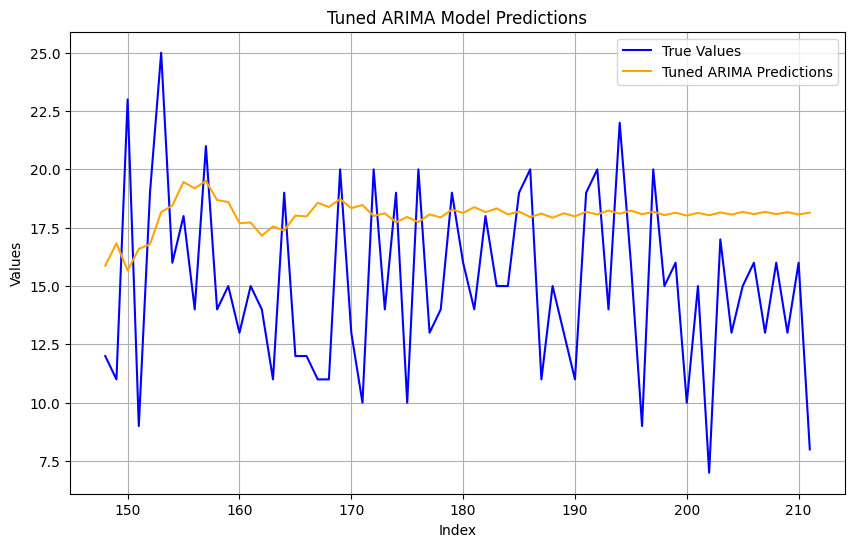

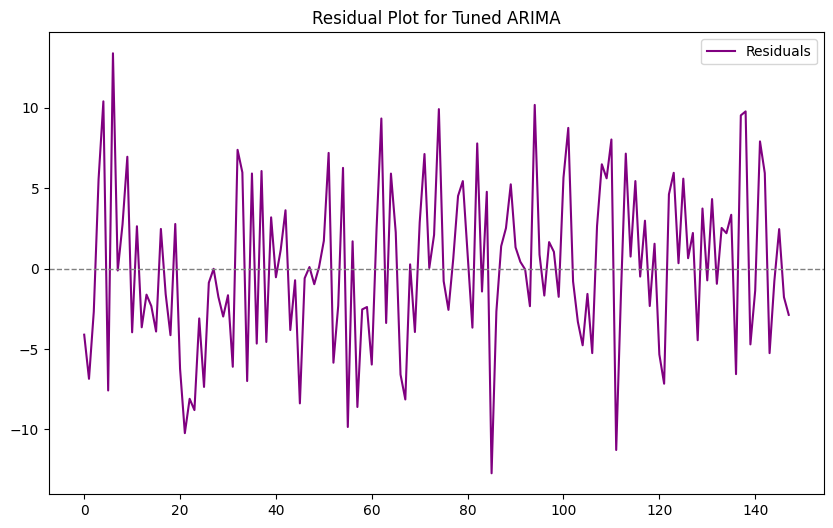

In [81]:
# Fit ARIMA with best parameters
arima_tuned_model = ARIMA(train,
                          order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_tuned_model_fit = arima_tuned_model.fit()

# Predict with ARIMA tuned
arima_tuned_predictions = arima_tuned_model_fit.forecast(len(test))

# Evaluate ARIMA tuned
arima_tuned_metrics = calculatemetrics(test, arima_tuned_predictions)
print("ARIMA Tuned Metrics:", arima_tuned_metrics)

# Plot ARIMA tuned predictions
plotmodelpredictions(test, arima_tuned_predictions, "Tuned ARIMA")
plot_residuals(arima_tuned_model_fit, "Tuned ARIMA")

Poor performance of model.
Widespread residual plot indicating higher values for residuals.

In [83]:
# SARIMA Hyperparameter Tuning
def objective_sarima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  # Fixed seasonal period (monthly data)

    # Fit SARIMA with trial parameters
    model = SARIMAX(train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s))
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for SARIMA
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(objective_sarima, n_trials=50)
best_sarima_params = study_sarima.best_params

# Print best SARIMA parameters
print("Best SARIMA Parameters:", best_sarima_params)

[I 2024-11-27 15:04:30,890] A new study created in memory with name: no-name-9f5c43ed-7a0c-418a-8831-d3c3d2959734
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
[I 2024-11-27 15:04:34,149] Trial 0 finished with value: 6.18535505319816 and parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 2, 'D': 0, 'Q': 1}. Best is trial 0 with value: 6.18535505319816.
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-27 15:04:39,202] Trial 1 finished with value: 7.638989373942856 and parameters: {'p': 5, 'd': 2, 'q': 5, 'P': 1, 'D': 1, 'Q': 1}. Best is trial 0 with value: 6.18535505319816.
C:

Best SARIMA Parameters: {'p': 3, 'd': 2, 'q': 1, 'P': 0, 'D': 1, 'Q': 2}


SARIMA Tuned Metrics: (np.float64(3.5372614906526727), np.float64(4.194545836535049), np.float64(17.594214774793517), np.float64(27.122222522821193))


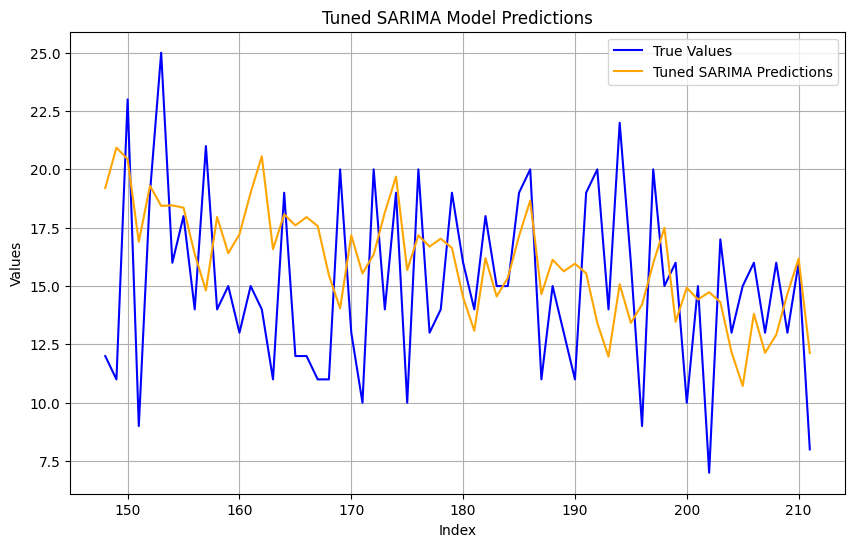

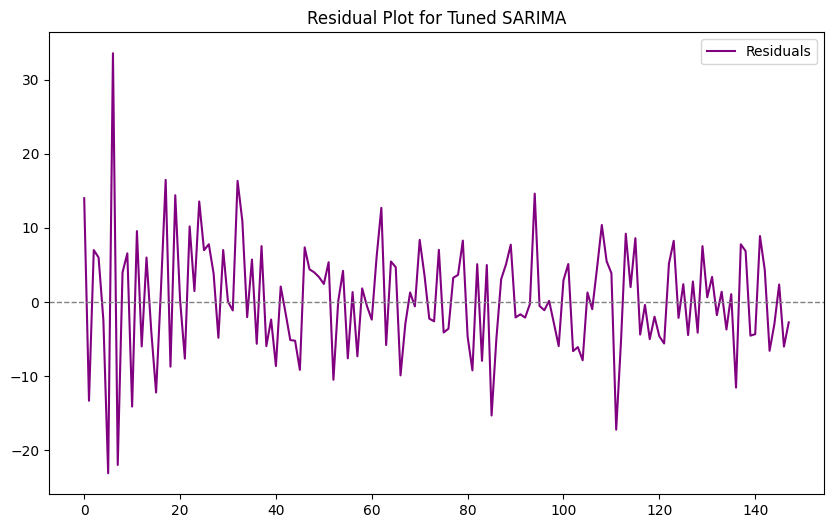

In [84]:
# Fit SARIMA with best parameters
sarima_tuned_model = SARIMAX(train,
                             order=(best_sarima_params['p'], best_sarima_params['d'], best_sarima_params['q']),
                             seasonal_order=(best_sarima_params['P'], best_sarima_params['D'], best_sarima_params['Q'], 12))
sarima_tuned_model_fit = sarima_tuned_model.fit()

# Predict with SARIMA tuned
sarima_tuned_predictions = sarima_tuned_model_fit.forecast(len(test))

# Evaluate SARIMA tuned
sarima_tuned_metrics = calculatemetrics(test, sarima_tuned_predictions)
print("SARIMA Tuned Metrics:", sarima_tuned_metrics)

# Plot SARIMA tuned predictions
plotmodelpredictions(test, sarima_tuned_predictions, "Tuned SARIMA")
plot_residuals(sarima_tuned_model_fit, "Tuned SARIMA")

Model captures seasonality.
Less spread residual plot indicating lower values for residuals.

In [86]:
def objective_arimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMAX model with trial parameters
    model = ARIMA(train, order=(p, d, q), exog=trainexog)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=testexog)

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for ARIMAX
study_arimax = optuna.create_study(direction='minimize')
study_arimax.optimize(objective_arimax, n_trials=50)
best_arimax_params = study_arimax.best_params

# Print best ARIMAX parameters
print("Best ARIMAX Parameters:", best_arimax_params)

[I 2024-11-27 15:09:25,783] A new study created in memory with name: no-name-51f51893-f52b-4ab6-83af-d1fe45cb5b43
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-27 15:09:33,698] Trial 0 finished with value: 4.804900381747826 and parameters: {'p': 3, 'd': 0,

Best ARIMAX Parameters: {'p': 4, 'd': 0, 'q': 4}


C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMAX Tuned Metrics: (np.float64(3.7566549941123224), np.float64(4.784379841611059), np.float64(22.89029046881426), np.float64(23.64871852540378))


C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


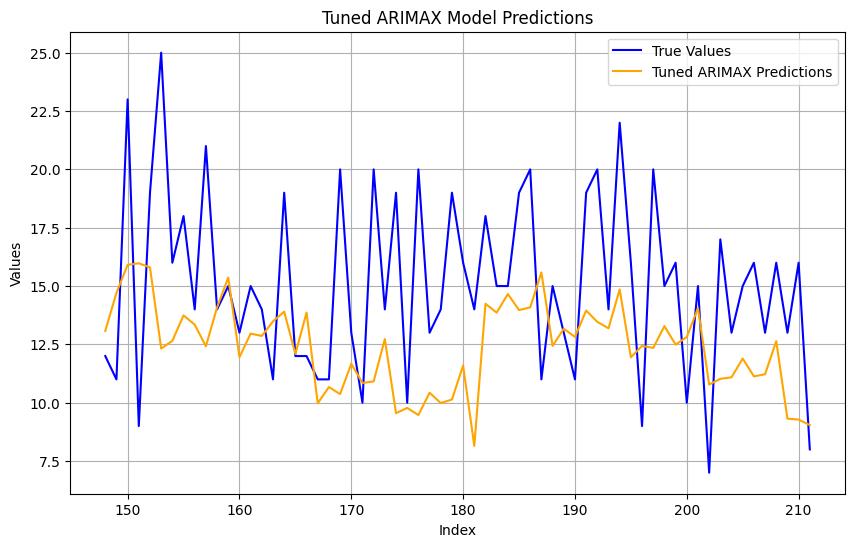

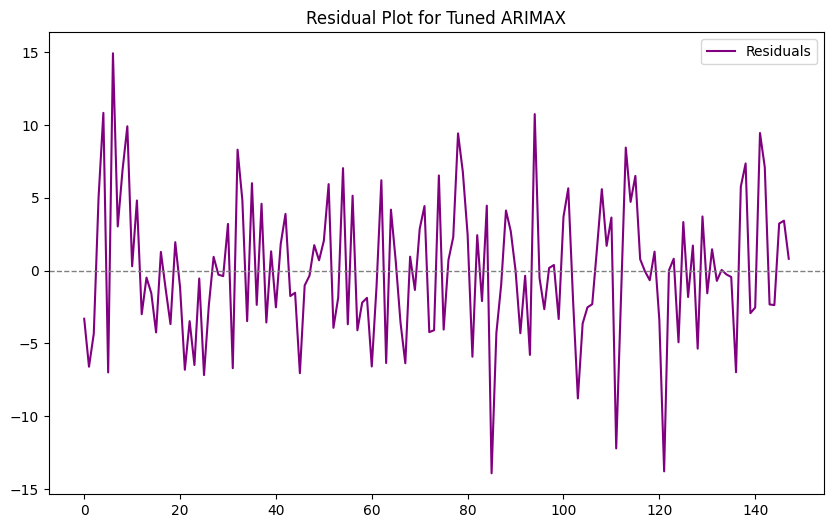

In [87]:
arimax_tuned_model = ARIMA(train,
                           order=(best_arimax_params['p'], best_arimax_params['d'], best_arimax_params['q']),
                           exog=trainexog)
arimax_tuned_model_fit = arimax_tuned_model.fit()

# Predict with ARIMAX tuned model
arimax_tuned_predictions = arimax_tuned_model_fit.forecast(len(test), exog=testexog)

# Evaluate ARIMAX tuned model
arimax_tuned_metrics = calculatemetrics(test, arimax_tuned_predictions)
print("ARIMAX Tuned Metrics:", arimax_tuned_metrics)

# Plot ARIMAX tuned predictions
plotmodelpredictions(test, arimax_tuned_predictions, "Tuned ARIMAX")
plot_residuals(arimax_tuned_model_fit, "Tuned ARIMAX")
     

Seasonality not captured accurately.
Residuals lesser compared to previous to previous models.

In [89]:
def objective_sarimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  # Fixed seasonal period (monthly data)

    # Fit SARIMAX with trial parameters
    model = SARIMAX(train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
    enforce_stationarity=True,
    enforce_invertibility=True,
                    exog=trainexog)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=testexog)

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))

# Create Optuna study for SARIMAX
study_sarimax = optuna.create_study(direction='minimize')
study_sarimax.optimize(objective_sarimax, n_trials=50)
best_sarimax_params = study_sarimax.best_params

# Print best SARIMAX parameters
print("Best SARIMAX Parameters:", best_sarimax_params)

[I 2024-11-27 15:19:19,008] A new study created in memory with name: no-name-330685fb-f4cf-4a61-85ff-eb8e9ba25912
[I 2024-11-27 15:19:24,766] Trial 0 finished with value: 7.268834582305231 and parameters: {'p': 4, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 2}. Best is trial 0 with value: 7.268834582305231.
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
[I 2024-11-27 15:19:26,249] Trial 1 finished with value: 7.185298166076908 and parameters: {'p': 2, 'd': 0, 'q': 5, 'P': 0, 'D': 0, 'Q': 0}. Best is trial 1 with value

Best SARIMAX Parameters: {'p': 5, 'd': 0, 'q': 5, 'P': 1, 'D': 1, 'Q': 2}


C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Aravind S\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Tuned Metrics: (np.float64(3.590847086917828), np.float64(4.475896768935529), np.float64(20.03365188616751), np.float64(26.744670738943594))


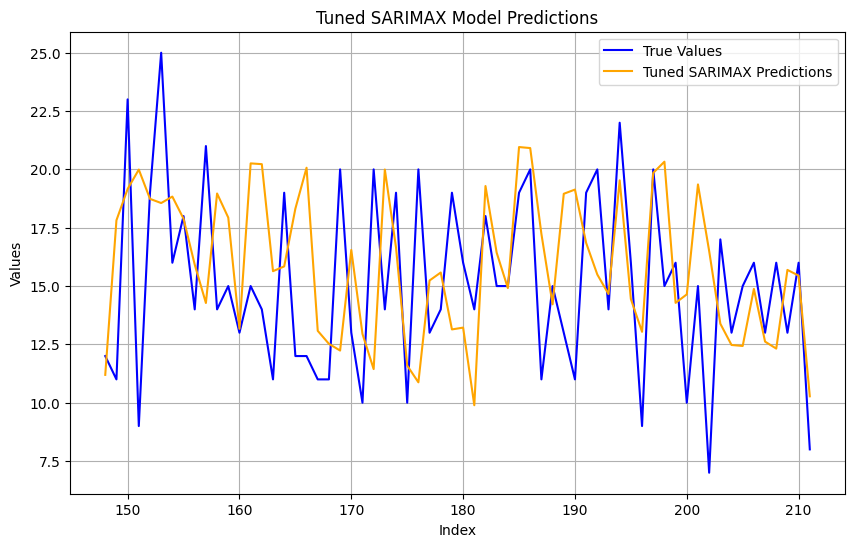

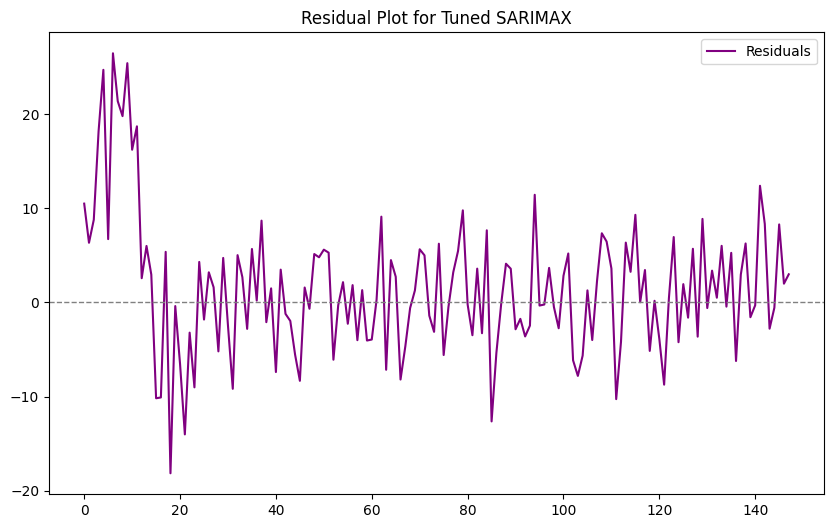

In [90]:
sarimax_tuned_model = SARIMAX(train,
                              order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),
                              seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),
                              exog=trainexog)
sarimax_tuned_model_fit = sarimax_tuned_model.fit()

# Predict with SARIMAX tuned model
sarimax_tuned_predictions = sarimax_tuned_model_fit.forecast(len(test), exog=testexog)

# Evaluate SARIMAX tuned model
sarimax_tuned_metrics = calculatemetrics(test, sarimax_tuned_predictions)
print("SARIMAX Tuned Metrics:", sarimax_tuned_metrics)

# Plot SARIMAX tuned predictions
plotmodelpredictions(test, sarimax_tuned_predictions, "Tuned SARIMAX")
plot_residuals(sarimax_tuned_model_fit, "Tuned SARIMAX")

Seasonality maximum captured,
Least residuals,
Residuals close to mid-value in Residual plot.

In [91]:
# Create table for evaluation metrics after tuning
metrics_after = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [armetrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],
    "RMSE": [armetrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],
    "MSE": [armetrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],
    "MAPE": [armetrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],
})

print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)


Evaluation Metrics After Hyperparameter Tuning
     Model       MAE      RMSE        MSE       MAPE
0       AR  4.250673  5.029975  25.300653  35.067471
1       MA  4.263641  5.047676  25.479036  35.192884
2    ARIMA  5.163597  6.115226  37.395990  42.898665
3   SARIMA  7.163782  8.197566  67.200091  57.438788
4   ARIMAX  3.756655  4.784380  22.890290  23.648719
5  SARIMAX  3.590847  4.475897  20.033652  26.744671


Highest RMSE for SARIMA

Lowest RMSE for SARIMAX

SARIMAX model captures more effectively. Therefore we are going to prefer SARIMAX timeseries modelling for future reference.